In [1]:
import os

from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
from rmgpy.species import Species
from rmgpy.data.kinetics import KineticsFamily, ReactionRecipe, KineticsDatabase

from rmg_helper_functions import find_reaction_folder, load_mechanism, get_rmg_reaction

import pandas as pd

In [2]:
database, reaction_list, species_dict = load_mechanism(
        'sih4_mech/chem_edge_annotated.inp', 'sih4_mech/species_edge_dictionary.txt')

Loading RMG Database ...
Finished loading RMG Database ...


('Silylene_Insertion\n', 'H2(11)+Si2(37)=SiH2Si(16)                           4.200e+06 1.970     -0.454   \n')
[Species(label="", molecule=[Molecule(SMILES="[H][H]")]), Species(label="", molecule=[Molecule(SMILES="[Si]=[Si]")])] [Species(label="", molecule=[Molecule(SMILES="[Si]=[SiH2]")])]


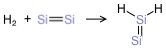

In [3]:
print reaction_list[5]
rxn = get_rmg_reaction(database, species_dict, 'Silylene_Insertion', reaction_list[5][1])
print rxn.reactants, rxn.products
rxn

In [4]:
def get_features(reaction):
    """
    Given a rmgpy.reaction.Reaction() 'reaction', calculate the value of 
    the features for this reaction and return as a dictionary
    
    Currently specific to Silylene Insertion reactions
    """
    features = ['reaction', 'H2', 'Sirad_H', 'Sirad_Si_H', 'Sid_H', 'Sid_Si_H', 'sil_H2', 'sil_rad', 'sil_d', 'Success Rate']
    feature_dict = dict.fromkeys(features[:-1], False)
    feature_dict.update(dict.fromkeys(['reaction'], 
                                      '+'.join([r.molecule[0].toSMILES() for r in reaction.reactants]) 
                                      + '_' + '+'.join([p.molecule[0].toSMILES() for p in reaction.products])))
    
    if '[H][H]' in [r.molecule[0].toSMILES() for r in reaction.reactants]:
        feature_dict.update(dict.fromkeys(['H2'], True))
    else:
        for r in reaction.reactants:
            try:
                si_h = r.molecule[0].getLabeledAtom('*1')
            except:
                pass
        if si_h.radicalElectrons > 0:
            feature_dict.update(dict.fromkeys(['Sirad_H'], True))
        for atom, bond in si_h.bonds.items():
            if atom.element.symbol == 'Si':
                if atom.radicalElectrons > 0:
                    feature_dict.update(dict.fromkeys(['Sirad_Si_H'], True))
                for atom2, bond2 in atom.bonds.items():
                    if atom2 != si_h and bond2.order == 'D':
                        feature_dict.update(dict.fromkeys(['Sid_Si_H'], True))
            if bond.order == 'D':
                feature_dict.update(dict.fromkeys(['Sid_H'], True))
    
    for r in reaction.reactants:
        try:
            sil_h = r.molecule[0].getLabeledAtom('*3')
        except:
            pass
    neighbor_atoms = [neighbor[0] for neighbor in sil_h.bonds.items()]
    if len(neighbor_atoms) == 2 and all([neighbor.symbol == 'H' for neighbor in neighbor_atoms]):
        feature_dict.update(dict.fromkeys(['sil_H2'], True))
    else:
        if sil_h.radicalElectrons > 0:
            feature_dict.update(dict.fromkeys(['sil_rad'], True))
        for atom, bond in sil_h.bonds.items():
            if bond.order == 'D':
                feature_dict.update(dict.fromkeys(['sil_d'], True))

    return feature_dict

In [5]:
print get_features(rxn)

{'sil_d': True, 'reaction': '[H][H]+[Si]=[Si]_[Si]=[SiH2]', 'sil_rad': False, 'Sid_H': False, 'H2': True, 'Sirad_H': False, 'sil_H2': False, 'Sirad_Si_H': False, 'Sid_Si_H': False}


In [6]:
def get_success(reaction):
    """
    Given a rmgpy.reaction.Reaction() 'reaction', get whether the TS calculation succeeded or how it
    failed (success, false positive, failure1, failure2)
    
    Currently, will only work if reaction is bimolecular->unimolecular (2 reactants->1)
    """
    scratch_dir = os.getenv('SCRATCH') 
    if scratch_dir is None:
        scratch_dir = os.getenv('RMGpy')
    
    success = None
    family = reaction.family
    try:
        my_folder = find_reaction_folder(reaction)
    except TypeError:
        print "Couldn't find any folders for the reaction: {0}+{1}->{2}".format(
            reaction.reactant[0].molecule[0].toSMILES(), reaction.reactant[1].molecule[0].toSMILES,
            reaction.product[0].molecule[0].toSMILES())
    
    if my_folder:
        if os.path.exists(os.path.join(scratch_dir, 'QMfiles/Reactions', family, 'false_positives', my_folder)):
            success = 'FP' # false positive
        else:
            if os.path.exists(os.path.join(scratch_dir, 'QMfiles/Reactions', family, my_folder, 'm062x', 'error.txt')):
                with open(os.path.join(scratch_dir, 'QMfiles/Reactions', family, my_folder, 'm062x', 'error.txt')) as error_file:
                    for line in error_file: # There should only be one
                        if line.strip().startswith('Success'):
                            success = 'S'
                            break
                        if line.strip().startswith('TS not converged'):
                            success = 'F1' # TS not converged failure
                            break
                        if line.strip().startswith('IRC failed'):
                            success = 'F2' # IRC failure
                            break
                if success is None:
                    print "Strange error {0} in reaction {1}".format(line, my_folder)
            elif os.path.exists(os.path.join(scratch_dir, 'QMfiles/Reactions', family, my_folder, 'm062x', 'optDists.txt')):
                success = 'S'
            else:
                print "Not sure about reaction {0}, has contents {1}".format(my_folder, 
                            ' , '.join(os.listdir(os.path.join(scratch_dir, 'QMfiles/Reactions', 
                                                               family, my_folder, 'm062x'))))

    return success

In [7]:
print get_success(rxn)

F2


In [8]:
def get_family_data(family):
    """
    Given a reaction family 'family' as string, returns a pandas.DataFrame that has the features for each
    reaction in a mechanism, in the family, that had a TS calculation done and what the success code is. 
    
    Features only will be relevant for silylene insertion
    """
    data = []

    rmg_database, reaction_list, species_dict = load_mechanism(
        'sih4_mech/chem_edge_annotated.inp', 'sih4_mech/species_edge_dictionary.txt')

    for reaction_tuple in reaction_list:
        rxn_family, reaction_line = reaction_tuple
        if rxn_family.strip() == family:
            reaction = get_rmg_reaction(rmg_database, species_dict, family, reaction_line)

            if reaction is not None:
                features_for_reaction = get_features(reaction)
                features_for_reaction['Success Code'] = get_success(reaction)
                data.append(features_for_reaction)
            else:
                print "No RMG reactions found for reaction {0}".format(reaction_line.split()[0])

    return pd.DataFrame().from_dict(data)

In [9]:
family_data = get_family_data('Silylene_Insertion')

Loading RMG Database ...
Finished loading RMG Database ...
No RMG reactions found for reaction SiH3SiH(8)+SiH3SiH(8)=H8Si4(10)
Not sure about reaction [H][H]+[SiH][SiH]=[SiH]_[SiH]=[SiH][SiH3], has contents estDists.txt
Not sure about reaction [H][H]+[Si]1[SiH][SiH2]1_[SiH]1[SiH2][SiH2]1, has contents 
Not sure about reaction [SiH2]+[Si]=[SiH2]_[Si]=[SiH][SiH3], has contents 
Not sure about reaction [SiH4]+[Si]=[Si]_[Si]=[SiH][SiH3], has contents 
Not sure about reaction [SiH3]+[SiH]_[SiH2][SiH2], has contents 
Not sure about reaction [SiH2][SiH3]+[SiH]_[SiH2][SiH2][SiH2], has contents 


In [10]:
print family_data.head()

      H2  Sid_H Sid_Si_H Sirad_H Sirad_Si_H Success Code  \
0  False  False    False   False      False           FP   
1  False  False    False    True      False           F2   
2   True  False    False   False      False            S   
3   True  False    False   False      False           F2   
4  False   True    False   False      False           FP   

                                  reaction sil_H2  sil_d sil_rad  
0     [SiH2]+[SiH][SiH3]_[SiH][SiH2][SiH3]   True  False   False  
1               [SiH3]+[SiH2]_[SiH2][SiH3]   True  False   False  
2         [H][H]+[Si]=[SiH2]_[SiH2]=[SiH2]  False   True   False  
3             [H][H]+[Si]=[Si]_[Si]=[SiH2]  False   True   False  
4  [SiH2]+[SiH2]=[SiH2]_[SiH2]=[SiH][SiH3]   True  False   False  


In [11]:
family_data = family_data[family_data['Success Code'].notnull()]
print family_data.shape

(84, 10)


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

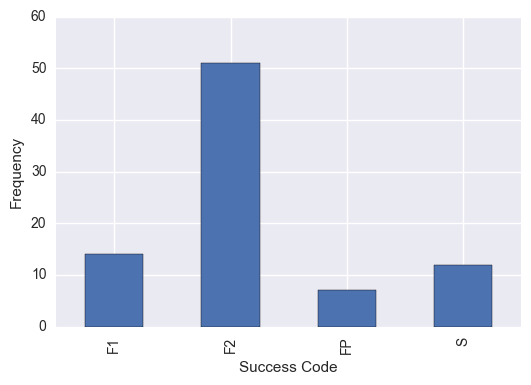

In [13]:
family_data.groupby('Success Code').size().plot(kind='bar')
plt.xlabel('Success Code')
plt.ylabel('Frequency')
plt.show()

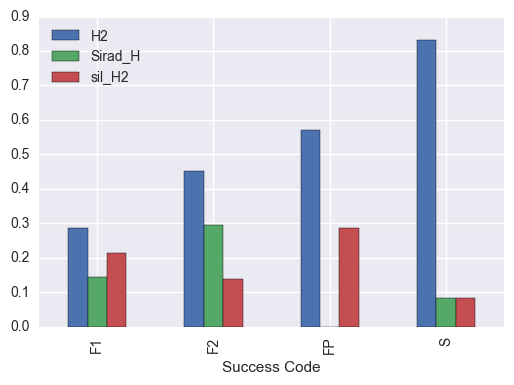

In [14]:
average_H2_value = family_data.groupby('Success Code')['H2', 'Sirad_H', 'sil_H2'].mean()
average_H2_value.plot.bar()

In [29]:
from sklearn.cross_validation import ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [58]:
y = family_data['Success Code']
X = family_data[[column for column in family_data.columns if column not in ['Success Code', 'reaction']]]

In [59]:
log_reg = LogisticRegression(class_weight='balanced')#)#LogisticRegression(multi_class='multinomial', solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=9)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [48]:
log_reg.score(X_test, y_test)

0.33333333333333331

In [49]:
print log_reg.coef_
print log_reg.classes_
print X.columns

[[-0.90887429 -0.39256192  0.         -1.08285807 -0.34011868  0.38676511
  -0.90485553  0.27446056]
 [-0.26252448 -0.14887944  0.          1.13325992  0.53554691 -0.6663393
  -0.19836672  0.08854409]
 [ 0.14009917  1.17564333  0.         -1.61544298 -0.85359262  0.8195382
   1.07119755 -0.00523718]
 [ 0.73694061 -0.54390818  0.         -0.3272543  -0.48986097 -0.16169698
   0.12608289 -1.04195759]]
['F1' 'F2' 'FP' 'S']
Index([u'H2', u'Sid_H', u'Sid_Si_H', u'Sirad_H', u'Sirad_Si_H', u'sil_H2',
       u'sil_d', u'sil_rad'],
      dtype='object')


In [50]:
zip(y_test, log_reg.predict(X_test))

[('F2', 'F2'),
 ('F1', 'F2'),
 ('S', 'S'),
 ('F2', 'S'),
 ('F1', 'F2'),
 ('F2', 'FP'),
 ('F2', 'FP'),
 ('F2', 'F2'),
 ('F2', 'S')]

Try doing StratifiedKFold for cross validation- keep training and test set with proportional number of class labels 

In [63]:
cv_skf = StratifiedKFold(y, random_state=9)
sum_scores = 0.0
for train_index, test_index in cv_skf:
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    log_reg.fit(X_train, y_train)
    sum_scores += log_reg.score(X_test, y_test)
    print log_reg.score(X_test, y_test)
    print zip(y_test, log_reg.predict(X_test))
    print '\n'
print "Avg score: {0}".format(round(sum_scores/len(cv_skf), 3))

0.48275862069
[('FP', 'F1'), ('F2', 'F2'), ('S', 'FP'), ('F2', 'FP'), ('FP', 'F1'), ('F2', 'FP'), ('S', 'F2'), ('F1', 'F2'), ('F2', 'F2'), ('FP', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'S'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F1', 'S'), ('F2', 'F2'), ('S', 'F2'), ('F2', 'S'), ('F1', 'F2'), ('S', 'S'), ('F2', 'F2'), ('F1', 'F2'), ('F1', 'F2')]


0.25
[('FP', 'S'), ('FP', 'F2'), ('F1', 'F2'), ('S', 'S'), ('S', 'FP'), ('F2', 'S'), ('F2', 'S'), ('F1', 'FP'), ('S', 'S'), ('S', 'S'), ('F2', 'FP'), ('F2', 'FP'), ('F2', 'FP'), ('F1', 'F2'), ('F1', 'S'), ('F2', 'S'), ('F2', 'S'), ('F2', 'S'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'S'), ('F2', 'F1'), ('F2', 'F2'), ('F2', 'S'), ('F2', 'S'), ('F2', 'S'), ('F1', 'F2')]


0.592592592593
[('FP', 'S'), ('S', 'F2'), ('S', 'F1'), ('S', 'F2'), ('S', 'F2'), ('FP', 'S'), ('F2', 'F2'), ('F1', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'), ('F2', 'F2'

In [64]:
predictions = log_reg.predict(X)
performance = pd.DataFrame(data=zip(y, predictions), columns = ['Actual', 'Prediction'])

In [108]:
cm = confusion_matrix(y, predictions, labels=['S', 'FP', 'F1', 'F2'])
cm_df = pd.DataFrame(data=cm, columns=['S', 'FP', 'F1', 'F2'])
print cm_df

   S  FP  F1  F2
0  2   0   1   9
1  2   3   0   2
2  0   1   6   7
3  1   3   5  42


In [109]:
percents = cm_df.iloc[:].transpose().apply(lambda x: x/x.sum()).transpose()

          S        FP        F1        F2
0  0.166667  0.000000  0.083333  0.750000
1  0.285714  0.428571  0.000000  0.285714
2  0.000000  0.071429  0.428571  0.500000
3  0.019608  0.058824  0.098039  0.823529


([<matplotlib.axis.XTick at 0x116e54d90>,
 <a list of 4 Text xticklabel objects>)

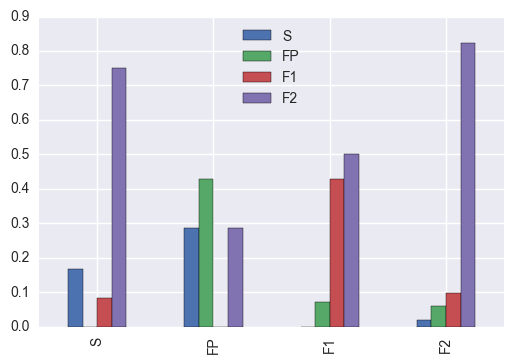

In [120]:
print percents
percents.plot.bar()
plt.xticks(np.arange(4), ('S', 'FP', 'F1', 'F2') )

#### Do a grid search to figure out best parameters for model (ie size of test set etc.)
#### Include more features, remove unnecessary (Sid_Si_H is always False for this set)

Remove features which may not be independent

For example, if H2 is true, then all the Si_H ones are false

In [60]:
X = family_data[[column for column in family_data.columns if column not in ['Success Code', 'reaction', 'H2', 'sil_H2']]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 9)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.33333333333333331